In [1]:
import sys
assert sys.version_info[0]==3
assert sys.version_info[1]>=8

# from platform import python_version
# assert int(python_version().split(".")[1]) >= 5, "Please upgrade your Python version following the instructions in \
#     the README.md file found in the same directory as this notebook. Your Python version is " + python_version()

from gensim.models import keyedvectors
from gensim.test.utils import datapath

import pprint
import matplotlib.pyplot as plt

from datasets import load_dataset
imdb_dataset=load_dataset("stanfordnlp/imdb")

import re
import numpy as np
import random
import scipy as sp 

from sklearn.decomposition import TruncatedSVD,PCA

np.random.seed(0)
random.seed(0)

/home/nathanael/Desktop/build/GloVe-python/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
START_TOKEN='<START>'
END_TOKEN='<END>'
NUM_SAMPLES=150


### Count-Based Word Vectors 


Many word vector implementations are driven by the idea that similar words, i.e., (near) synonyms, will be used in similar contexts. As a result, similar words will often be spoken or written along with a shared subset of words, i.e., contexts. By examining these contexts, we can try to develop embeddings for our words. With this intuition in mind, many "old school" approaches to constructing word vectors relied on word counts. Here we elaborate upon one of those strategies, *co-occurrence matrices* (for more information, see [here](https://web.stanford.edu/~jurafsky/slp3/6.pdf) or [here](https://web.archive.org/web/20190530091127/https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285)).

#### Plotting Co-Occurrence Word Embeddings

Here, we will be using the Large Movie Review Dataset. This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well. We provide a `read_corpus` function below that pulls out the text of a movie review from the dataset. The function also adds `<START>` and `<END>` tokens to each of the documents, and lowercases words. You do **not** have to perform any other kind of pre-processing.

In [3]:
imdb_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [4]:
"""
for split in ["train","test","unsupervised"]:
    print(f"{split.capitalize()} split")

    for example in imdb_dataset[split]:
        print("text: ", example["text"])
        print("Label: ", example["label"])
        print()
"""

'\nfor split in ["train","test","unsupervised"]:\n    print(f"{split.capitalize()} split")\n\n    for example in imdb_dataset[split]:\n        print("text: ", example["text"])\n        print("Label: ", example["label"])\n        print()\n'

In [5]:
def read_corpus():
    files=imdb_dataset["train"]["text"][:NUM_SAMPLES]
    return [[START_TOKEN]+ [re.sub(r'[^\w]','',w.lower()) for w in f.split(" ")]+[END_TOKEN] for f in files]

In [6]:
imdb_corpus=read_corpus()
pprint.pprint(imdb_corpus[:3],compact=True,width=100)

[['<START>', 'i', 'rented', 'i', 'am', 'curiousyellow', 'from', 'my', 'video', 'store', 'because',
  'of', 'all', 'the', 'controversy', 'that', 'surrounded', 'it', 'when', 'it', 'was', 'first',
  'released', 'in', '1967', 'i', 'also', 'heard', 'that', 'at', 'first', 'it', 'was', 'seized',
  'by', 'us', 'customs', 'if', 'it', 'ever', 'tried', 'to', 'enter', 'this', 'country', 'therefore',
  'being', 'a', 'fan', 'of', 'films', 'considered', 'controversial', 'i', 'really', 'had', 'to',
  'see', 'this', 'for', 'myselfbr', 'br', 'the', 'plot', 'is', 'centered', 'around', 'a', 'young',
  'swedish', 'drama', 'student', 'named', 'lena', 'who', 'wants', 'to', 'learn', 'everything',
  'she', 'can', 'about', 'life', 'in', 'particular', 'she', 'wants', 'to', 'focus', 'her',
  'attentions', 'to', 'making', 'some', 'sort', 'of', 'documentary', 'on', 'what', 'the', 'average',
  'swede', 'thought', 'about', 'certain', 'political', 'issues', 'such', 'as', 'the', 'vietnam',
  'war', 'and', 'race', 'issu

In [7]:
print("corpus size is : " , len(imdb_corpus[1]))

corpus size is :  216


distinct words

In [8]:
def Distinct_words(corpus):
    corpus_words=set()
    n_corpus_words=0
    
    for document in corpus:
        for word in document:
            corpus_words.add(word)

    corpus_words=sorted(corpus_words)
    n_corpus_words=len(corpus_words)
    return corpus_words,n_corpus_words


In [9]:
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
test_corpus_words, num_corpus_words = Distinct_words(test_corpus)

In [10]:
test_corpus_words,num_corpus_words

(['<END>',
  '<START>',
  'All',
  "All's",
  'ends',
  'glitters',
  'gold',
  "isn't",
  'that',
  'well'],
 10)

In [11]:
# Correct answers
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
ans_num_corpus_words = len(ans_test_corpus_words)

# Test correct number of words
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)
# Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


compute co-occurrence matrix

In [12]:
def compute_cooccurrence_matrix(corpus,window_size=4): #window 4 is the defult
    words,n_words=Distinct_words(corpus)
    M=np.zeros((n_words,n_words))
    word2ind={}

    for document in corpus:
        word2ind={ word: idx for idx,word in enumerate(words)}
        for i , word in enumerate(document):
            word_indx=word2ind[word]
            start=max(0,i-window_size)
            end=min(len(document),i+window_size+1)
            for j in range(start,end):
                if i!=j:
                    context_word=document[j]
                    context_word_idx=word2ind[context_word]
                    M[word_indx,context_word_idx]+=1
    return M,word2ind


In [13]:
new_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
Matrix,word2ind=compute_cooccurrence_matrix(new_corpus,window_size=1)
Matrix

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
       [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.],
       [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.]])

In [14]:
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_cooccurrence_matrix(test_corpus, window_size=1)

# Correct M and word2ind
M_test_ans = np.array( 
    [[0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,],
     [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,]]
)
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
word2ind_ans = dict(zip(ans_test_corpus_words, range(len(ans_test_corpus_words))))

# Test correct word2ind
assert (word2ind_ans == word2ind_test), "Your word2ind is incorrect:\nCorrect: {}\nYours: {}".format(word2ind_ans, word2ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2ind_ans.keys():
    idx1 = word2ind_ans[w1]
    for w2 in word2ind_ans.keys():
        idx2 = word2ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


reduce K_dimension

In [15]:
from sklearn.decomposition import TruncatedSVD
def reduce_k_dim(M,k=2):
    n_iters=10
    M_reduced=True
    print("Running Truncated SVD over %i words..." % (M.shape[0]))

    svd=TruncatedSVD(n_components=k,n_iter=n_iters,random_state=42)
    M_reduced=svd.fit_transform(M)
    print("Done.")
    return M_reduced

In [16]:
M_test_reduced = reduce_k_dim(M_test, k=2)
M_test_reduced

Running Truncated SVD over 10 words...
Done.


array([[ 6.54802087e-01, -7.83221122e-01],
       [ 5.20200324e-01, -4.16333634e-16],
       [ 7.05647176e-01,  4.84057274e-01],
       [ 7.05647176e-01, -4.84057274e-01],
       [ 1.02780472e+00,  9.43689571e-16],
       [ 6.54802087e-01,  7.83221122e-01],
       [ 3.82258491e-01,  6.56224003e-01],
       [ 3.82258491e-01, -6.56224003e-01],
       [ 1.39420808e+00, -1.06179274e+00],
       [ 1.39420808e+00,  1.06179274e+00]])

In [17]:
# Define toy corpus and run student code
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_cooccurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_k_dim(M_test, k=2)

# Test proper dimensions
assert (M_test_reduced.shape[0] == 10), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 10)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

Running Truncated SVD over 10 words...
Done.
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


plot_embeddings in 2d space

In [18]:
def plot_embeddings(M_reduced,word2ind,words):
    plt.figure(figsize=(12,8))
    for word in words:
        idx=word2ind[word]
        embedding=M_reduced[idx]
        plt.scatter(embedding[0],embedding[1],marker="o",color="blue",s=100)
        plt.text(embedding[0], embedding[1], word, fontsize=9)
        plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('Word Embeddings Visualization')
    plt.grid(True)
    plt.show()

--------------------------------------------------------------------------------
Outputted Plot:


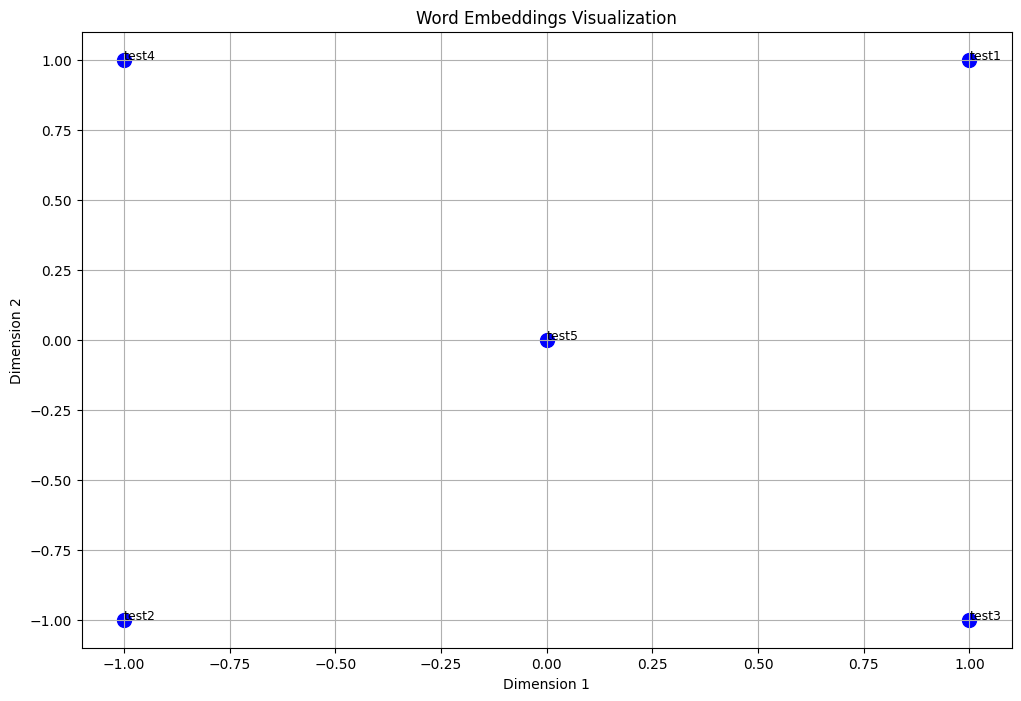

--------------------------------------------------------------------------------


In [19]:
print ("-" * 80)
print ("Outputted Plot:")

M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2ind_plot_test, words)

print ("-" * 80)

co occurrence plot analysis

In [24]:
import nltk
nltk.download("reuters")

[nltk_data] Downloading package reuters to
[nltk_data]     /home/nathanael/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


True

In [27]:
from nltk.corpus import reuters
def read_corpus_reuters(category=):
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]

In [28]:
reuters_corpus = read_corpus_reuters()
M_co_occurrence, word2ind_co_occurrence = compute_cooccurrence_matrix(reuters_corpus)
pprint.pprint(M_co_occurrence)
pprint.pprint(word2ind_co_occurrence)
M_reduced_co_occurrence = reduce_k_dim(M_co_occurrence, k=2)
pprint.pprint(M_reduced_co_occurrence)
pprint.pprint(M_reduced_co_occurrence.shape)
pprint.pprint(M_co_occurrence.shape)

array([[78.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])
{'"': 0,
 '"(': 1,
 '",': 2,
 '"...': 3,
 '$': 4,
 '&': 5,
 "'": 6,
 '(': 7,
 ')': 8,
 ')"': 9,
 '),': 10,
 '),"': 11,
 ').': 12,
 ')."': 13,
 ')...': 14,
 ')/': 15,
 ',': 16,
 ',"': 17,
 '-': 18,
 '--': 19,
 '.': 20,
 '."': 21,
 '.(': 22,
 '.)': 23,
 '.,': 24,
 '.,"': 25,
 '.-': 26,
 '...': 27,
 '..."': 28,
 '...,"': 29,
 '....': 30,
 '.....': 31,
 '......': 32,
 '.......': 33,
 '........': 34,
 '.........': 35,
 '..........': 36,
 '...........': 37,
 '............': 38,
 '................': 39,
 './': 40,
 '.>': 41,
 '.>,': 42,
 '/': 43,
 '0': 44,
 '00': 45,
 '000': 46,
 '001': 47,
 '01': 48,
 '011': 49,
 '014': 50,
 '015': 51,
 '02': 52,
 '020': 53,
 '023': 54,
 '0230': 55,
 '03': 56,
 '0300': 57,
 '036': 58,
 

In [29]:
# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

M_normalized

array([[ 0.98750922,  0.15756123],
       [ 0.99184344,  0.12746215],
       [ 0.97435474, -0.22501741],
       ...,
       [ 0.95936328,  0.28217386],
       [ 0.98010885,  0.19846067],
       [ 0.995596  , -0.09374751]])

In [35]:
for word in words:
    if word not in word2ind_co_occurrence:
        print(f"Word '{word}' not found in word2ind_co_occurrence dictionary.")

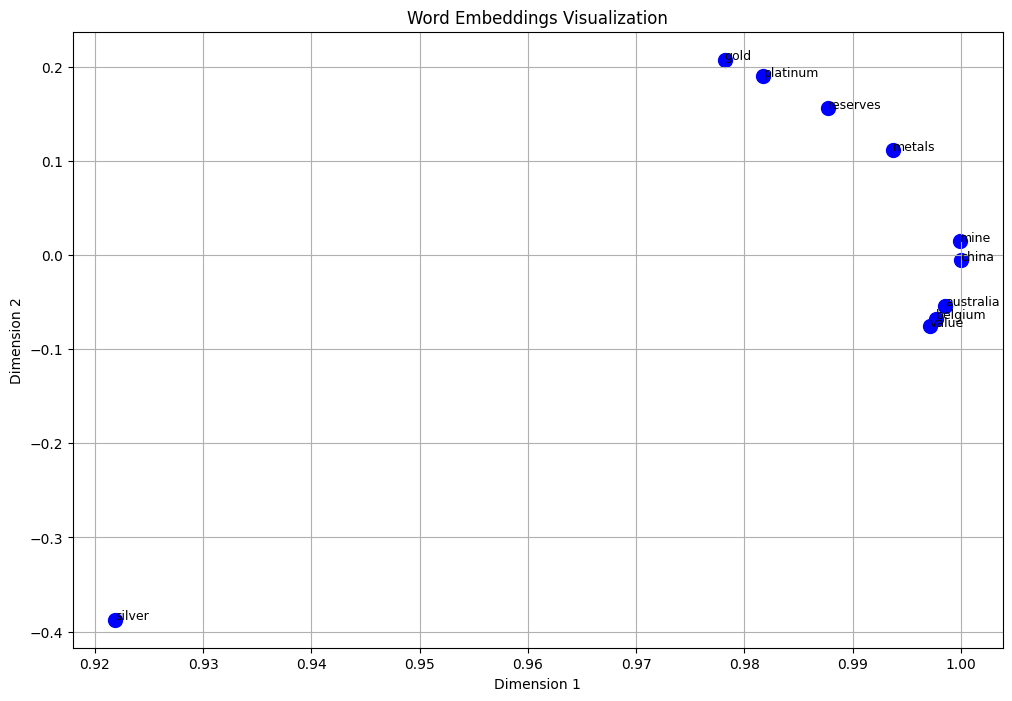

In [33]:
words = ['value', 'gold', 'platinum', 'reserves', 'silver', 'metals', 'belgium', 'australia', 'china', "mine"]

plot_embeddings(M_normalized, word2ind_co_occurrence, words)

### prediction based word vector

In [38]:
import gensim.downloader as api
def load_embedding_model():
    wv_from_bin=api.load("glove-wiki-gigaword-200")
    return wv_from_bin

In [39]:
wv_from_bin=load_embedding_model()

[==================================================] 100.0% 252.1/252.1MB downloaded


In [42]:
len(wv_from_bin.index_to_key)

400000

In [48]:
wv_from_bin.get_vector("messi")

array([-1.9471e-01, -1.5568e-01, -1.5546e+00,  4.7124e-01,  3.8236e-01,
       -6.5986e-02,  4.8791e-01,  5.8793e-01,  8.0440e-01,  2.0114e-01,
       -6.7813e-01,  8.1540e-01,  4.9042e-01,  9.5538e-01, -4.6860e-01,
       -3.0249e-01,  6.8837e-01, -5.6183e-03, -5.0914e-02, -8.6015e-01,
        4.9484e-01,  5.5280e-01, -3.4449e-01,  8.6760e-03,  5.1969e-01,
       -3.3178e-01, -3.2518e-01, -3.9283e-01, -8.3160e-01,  1.9946e-01,
       -1.9972e-01, -2.3724e-01, -4.6175e-01, -6.3415e-01, -2.4389e-01,
       -4.7042e-01, -4.7070e-01,  1.9227e-01,  2.1049e-01,  4.0507e-03,
       -8.3975e-01, -1.0060e-01,  1.5595e-01, -4.0905e-02,  4.1985e-01,
        5.4708e-01,  2.5456e-02,  5.5720e-02, -8.5570e-01,  3.5344e-01,
        3.0278e-01, -5.9817e-01,  3.7397e-01,  5.2088e-01, -1.9368e-01,
        9.4278e-01, -1.8923e-01, -3.3144e-01,  1.9607e-01, -4.5805e-01,
       -5.8020e-01, -7.7983e-01, -4.7696e-01,  8.0366e-02, -2.1224e-01,
        3.9933e-02,  4.5562e-02,  1.5410e-01,  4.8085e-01,  4.57

reduce dimensionality

In [52]:
def get_matrix_of_vector(wv_from_bin,required_words):
    import random
    words=list(wv_from_bin.index_to_key)
    print("shuffling words ....")
    random.seed(225)
    random.shuffle(words)
    words=words[:10000]
    print("printing %i words into word2vec and matrix M...")
    word2ind={}
    M=[]
    curInd=0
    for w in words:
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w]=curInd
            curInd+=1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.get_vector(w))
            word2ind[w]=curInd
            curInd+=1
        except KeyError:
            continue
    
    M=np.stack(M)
    print("done.")
    return M,word2ind


In [54]:
M, word2ind = get_matrix_of_vector(wv_from_bin, words)
pprint.pprint(M)
pprint.pprint(word2ind)
M_reduced = reduce_k_dim(M, k=2)
pprint.pprint(M_reduced)

shuffling words ....
printing %i words into word2vec and matrix M...
done.
array([[-0.010729 , -0.023046 ,  0.34935  , ...,  0.072801 , -0.083989 ,
        -0.25194  ],
       [-0.46948  , -0.084352 , -0.27956  , ..., -0.018965 , -0.21411  ,
        -0.91731  ],
       [ 0.22785  ,  0.085184 ,  0.0035642, ...,  0.061208 ,  0.10439  ,
        -0.90203  ],
       ...,
       [ 0.15119  ,  0.61394  , -0.58009  , ..., -0.14215  ,  0.11564  ,
         0.45879  ],
       [ 0.58774  ,  0.3612   , -0.11296  , ...,  0.13588  , -0.32117  ,
         0.057076 ],
       [-0.46352  ,  0.79832  , -0.4294   , ..., -0.27754  , -0.29254  ,
        -0.063247 ]], dtype=float32)
{'#aabccc': 1273,
 "'00": 7545,
 "'36": 9729,
 "'63": 2308,
 "'cause": 7041,
 '(215)': 6821,
 '(352)': 5304,
 '(525)': 5862,
 '+.05': 423,
 '+.25': 5857,
 '+0.4': 3094,
 '+11': 3136,
 '+45': 3041,
 ',108': 9850,
 ',530': 7171,
 ',820': 864,
 '-----------------------': 1759,
 '-2006': 104,
 '-4.1': 274,
 '-51': 3016,
 '.000435': 613

In [55]:
# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis] # broadcasting
pprint.pprint(M_lengths)
pprint.pprint(M_reduced_normalized)

array([1.1418566, 0.7873767, 2.1981602, ..., 3.2929082, 3.7542825,
       1.9170278], dtype=float32)
array([[-0.7881054 , -0.6155403 ],
       [-0.95413554,  0.29937494],
       [-0.86575943,  0.5004604 ],
       ...,
       [ 0.9974882 ,  0.0708334 ],
       [ 0.9836147 , -0.18028356],
       [ 0.99495494, -0.10032307]], dtype=float32)


glove plot anaysis

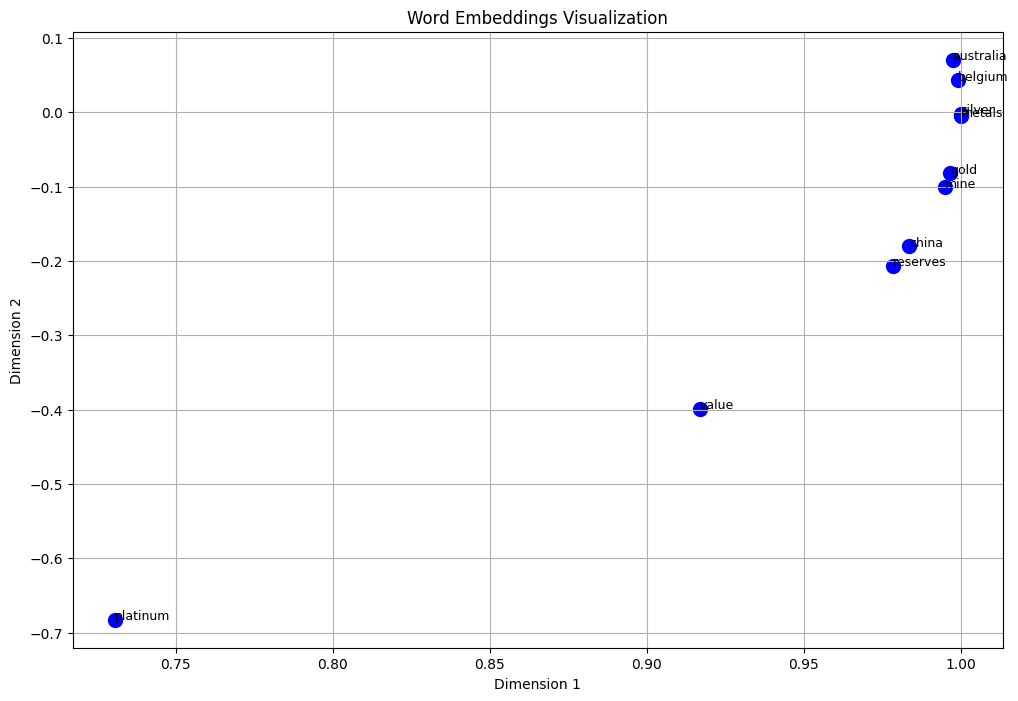

In [58]:
words = ['value', 'gold', 'platinum', 'reserves', 'silver', 'metals',  'belgium', 'australia', 'china', "mine"]
plot_embeddings(M_reduced_normalized, word2ind, words)

Words with Multiple Meanings   (Polysemes and homonyms )
> For example, "leaves" has both "go_away" and "a_structure_of_a_plant" meaning in the top 10, and "scoop" has both "handed_waffle_cone" and "lowdown". You will probably need to try several polysemous or homonymic words before you find one.



In [63]:
import gensim
words=wv_from_bin.index_to_key
words_to_try = ["bank", "bat", "bark", "crane", "date", "foot", "leaves", "scoop"]

for word in words_to_try:
    try:
        similar_words=wv_from_bin.most_similar(word)
        print(f"similar words :{similar_words}")

    except KeyError:
        print(f"the {word} isnt avaliable in the dictionary")


similar words :[('banks', 0.7625691294670105), ('banking', 0.6818838119506836), ('central', 0.6283639073371887), ('financial', 0.6166563034057617), ('credit', 0.6049750447273254), ('lending', 0.5980608463287354), ('monetary', 0.5963003039360046), ('bankers', 0.5913101434707642), ('loans', 0.5802939534187317), ('investment', 0.5740203261375427)]
similar words :[('bats', 0.691724419593811), ('batting', 0.6160588264465332), ('balls', 0.5692734122276306), ('batted', 0.5530908107757568), ('toss', 0.5506128668785095), ('wicket', 0.5495278835296631), ('pitch', 0.5489361882209778), ('bowled', 0.5452010631561279), ('hitter', 0.5353438854217529), ('batsman', 0.5348091125488281)]
similar words :[('twigs', 0.6458560824394226), ('mottled', 0.5284397602081299), ('birch', 0.5247510671615601), ('mulch', 0.5244165658950806), ('sawdust', 0.5125024318695068), ('trees', 0.5100499391555786), ('scaly', 0.5024779438972473), ('tree', 0.4941452145576477), ('cinchona', 0.49377116560935974), ('twig', 0.491233319

Synonyms & Antonyms 
> Find three words  
(
w
1
,
w
2
,
w
3
)
  where  
w
1
  and  
w
2
  are synonyms and  
w
1
  and  
w
3
  are antonyms, but Cosine Distance  
(
w
1
,
w
3
)
<
  Cosine Distance  
(
w
1
,
w
2
)
 .

 As an example,  
w
1
 ="happy" is closer to  
w
3
 ="sad" than to  
w
2
 ="cheerful"

In [66]:
wv_from_bin.distance("dad","son")

0.4248652458190918

In [68]:
wv_from_bin.n_similarity(['sushi', 'shop'], ['japanese', 'restaurant'])


0.6431498

Analogies with Word Vectors

In [69]:
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'grandfather'], negative=['man']))

[('grandmother', 0.7608445286750793),
 ('granddaughter', 0.7200808525085449),
 ('daughter', 0.7168302536010742),
 ('mother', 0.7151536345481873),
 ('niece', 0.7005682587623596),
 ('father', 0.6659887433052063),
 ('aunt', 0.6623408794403076),
 ('grandson', 0.6618767976760864),
 ('grandparents', 0.644661009311676),
 ('wife', 0.6445354223251343)]


Finding Analogies

In [71]:
wv_from_bin.most_similar(positive=['queen', 'man'], negative=['king'])

[('woman', 0.7250837087631226),
 ('girl', 0.5886719226837158),
 ('she', 0.5709657669067383),
 ('her', 0.5615235567092896),
 ('mother', 0.553316056728363),
 ('person', 0.5315726399421692),
 ('boy', 0.5261016488075256),
 ('teenager', 0.5241419076919556),
 ('beautiful', 0.5178192257881165),
 ('men', 0.515008270740509)]

In [82]:
x, y, a, b = "man", "king", "woman", "queen"
wv_from_bin.most_similar(positive=[a, y], negative=[b])[0][0]

'man'

Incorrect Analogy 

In [83]:
pprint.pprint(wv_from_bin.most_similar(positive=['foot', 'glove'], negative=['hand']))

[('45,000-square', 0.4922032654285431),
 ('15,000-square', 0.4649604558944702),
 ('10,000-square', 0.4544755816459656),
 ('6,000-square', 0.44975775480270386),
 ('3,500-square', 0.444133460521698),
 ('700-square', 0.44257497787475586),
 ('50,000-square', 0.4356396794319153),
 ('3,000-square', 0.43486514687538147),
 ('30,000-square', 0.4330596923828125),
 ('footed', 0.43236875534057617)]


Guided Analysis of Bias in Word Vectors 

In [88]:
pprint.pprint(wv_from_bin.most_similar(positive=['man', 'profession'], negative=['woman']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'profession'], negative=['man']))

[('reputation', 0.5250176787376404),
 ('professions', 0.5178037881851196),
 ('skill', 0.49046966433525085),
 ('skills', 0.49005505442619324),
 ('ethic', 0.4897659420967102),
 ('business', 0.4875852167606354),
 ('respected', 0.485920250415802),
 ('practice', 0.482104629278183),
 ('regarded', 0.4778572618961334),
 ('life', 0.4760662019252777)]

[('professions', 0.5957457423210144),
 ('practitioner', 0.49884122610092163),
 ('teaching', 0.48292139172554016),
 ('nursing', 0.48211804032325745),
 ('vocation', 0.4788965880870819),
 ('teacher', 0.47160351276397705),
 ('practicing', 0.46937814354896545),
 ('educator', 0.46524327993392944),
 ('physicians', 0.4628995358943939),
 ('professionals', 0.4601394236087799)]


In [90]:
import pprint

result_man_doctor = wv_from_bin.most_similar(positive=['woman', 'doctor'], negative=['man'])
pprint.pprint(result_man_doctor)
print()
result_man_engineer = wv_from_bin.most_similar(positive=['woman', 'engineer'], negative=['man'])
pprint.pprint(result_man_engineer)
print()
result_man_nurse = wv_from_bin.most_similar(positive=['woman', 'nurse'], negative=['man'])
pprint.pprint(result_man_nurse)


[('nurse', 0.6813318729400635),
 ('physician', 0.6672453284263611),
 ('doctors', 0.6173422336578369),
 ('dentist', 0.5775880217552185),
 ('surgeon', 0.5691418647766113),
 ('hospital', 0.564996600151062),
 ('pregnant', 0.5649074912071228),
 ('nurses', 0.5590692758560181),
 ('medical', 0.5542059540748596),
 ('patient', 0.5518484711647034)]

[('technician', 0.5853330492973328),
 ('engineers', 0.5717717409133911),
 ('educator', 0.5450620651245117),
 ('engineering', 0.48699602484703064),
 ('contractor', 0.48567914962768555),
 ('nurse', 0.48517873883247375),
 ('schoolteacher', 0.4825061857700348),
 ('teacher', 0.474063903093338),
 ('mechanic', 0.4704253673553467),
 ('married', 0.4676801860332489)]

[('nurses', 0.6442356705665588),
 ('pregnant', 0.6110885739326477),
 ('midwife', 0.591461181640625),
 ('mother', 0.5634385943412781),
 ('nursing', 0.5633082985877991),
 ('therapist', 0.554648220539093),
 ('anesthetists', 0.5426579713821411),
 ('anesthetist', 0.5350443720817566),
 ('pediatrician', 